In [8]:
import torch

# from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from PIL import Image
from tqdm import tqdm
import random
import os


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# transform = transforms.Compose(
#     [
#         transforms.Resize((200, 200)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(10),
#     ]
# )

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


In [3]:
train_dir = "C:/Users/mbele/Desktop/AIM1 TERM 2/Deep Learning with Pytorch/Project/asl_alphabet_train"
test_dir = "C:/Users/mbele/Desktop/AIM1 TERM 2/Deep Learning with Pytorch/Project/asl_alphabet_test"


In [4]:
train_ds = datasets.ImageFolder(root=train_dir, transform=transform)
labels = train_ds.classes


In [5]:
# dict = {"image":img, 'label':labels}
# pd.DataFrame(img, labels, columns=["image", "labels"])


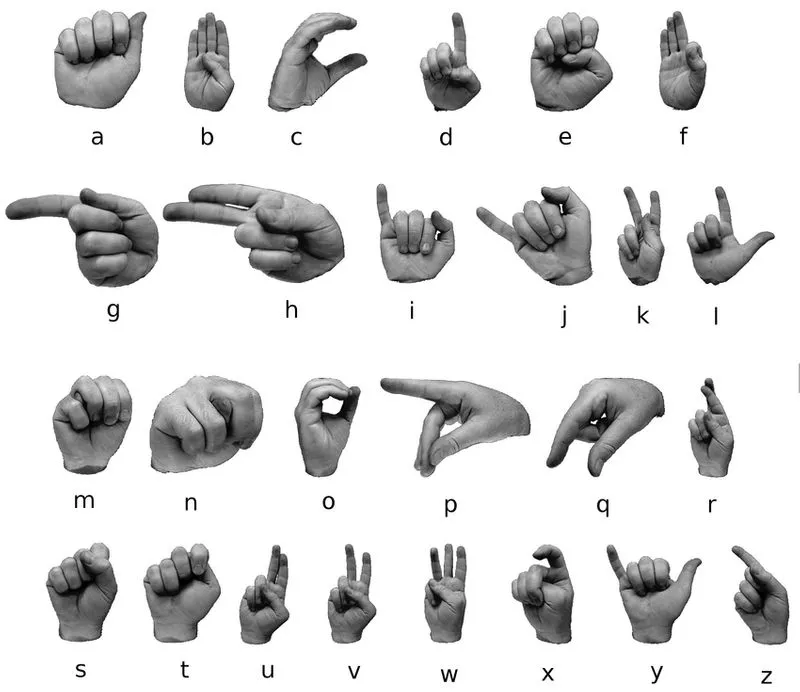


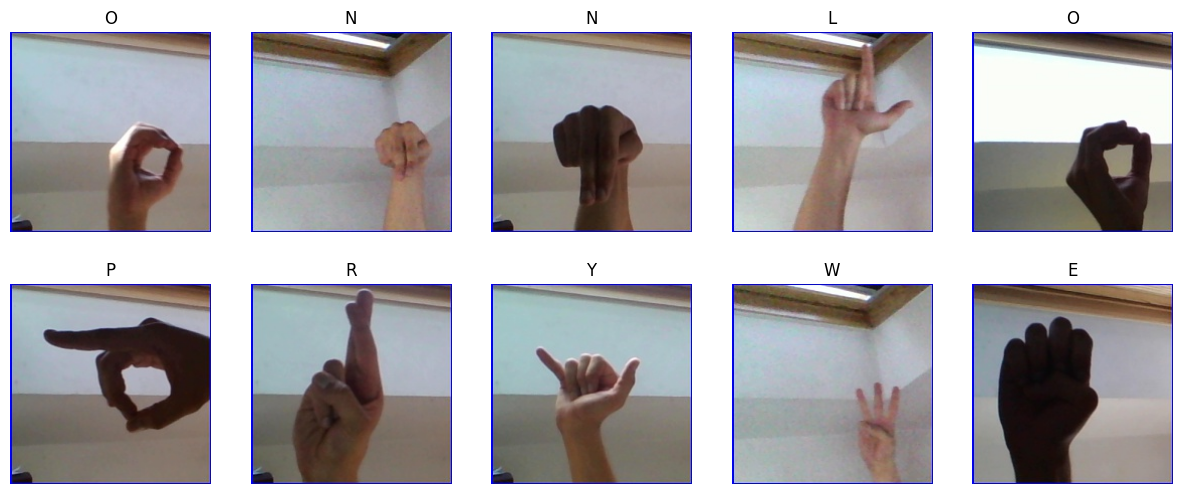

In [5]:
# for item in train_ds.samples:
#     img = Image.open(item[0])
#     plt.imshow(img)

rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

for ax in axes:
    index = random.randint(0, len(train_ds.samples))
    ax.axis("off")
    img_path = train_ds.samples[index][0]
    img = Image.open(img_path)
    ax.set_title(f"{labels[train_ds.samples[index][1]]}")
    ax.imshow(img)
    # plt.show()


## Splitting data into train and validation sets


#### taking a subset of dataset


In [7]:
# from torch.utils.data import DataLoader, Subset
# from torchvision import datasets, transforms
# import numpy as np

# # batch_size = 128

# train_ds = datasets.ImageFolder(root=train_dir, transform=transform)

# samples_per_class = 2000  # number of samples

# class_indices = {}
# for idx, (data, label) in enumerate(train_ds):
#     if label not in class_indices:
#         class_indices[label] = []
#     class_indices[label].append(idx)

# subset_indices = []
# for label, indices in class_indices.items():
#     if len(indices) < samples_per_class:
#         raise ValueError(
#             f"Not enough samples in class {label} to satisfy samples_per_class={samples_per_class}"
#         )
#     subset_indices.extend(np.random.choice(indices, samples_per_class, replace=False))

# subset_ds = Subset(train_ds, subset_indices)

# subset_loader = DataLoader(subset_ds, batch_size=batch_size, shuffle=True)


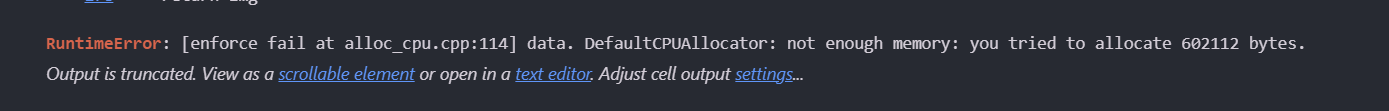


In [6]:
train_val, test_set = train_test_split(
    train_ds,
    test_size=0.2,
    shuffle=True,
    # stratify=[train_ds.targets[i] for i in range(num_samples)], # just testing it out
)

train_set, val_set = train_test_split(
    train_val,
    test_size=0.3,
    shuffle=True,
    # stratify=[train_ds.targets[i] for i in range(num_samples)], # just testing
)
len(train_set), len(val_set), len(test_set)


(48720, 20880, 17400)

In [9]:
batch_size = 28

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_set, batch_size=batch_size)
# for image, label in testloader:
#     print(image.shape, label.shape)


## Building model


## using pretrained network (RESNET18)


In [10]:
# model = models.resnet18(pretrained=True)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 29)  # since there are 29 classes

# move model to GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)


## Finding Best Learning rate


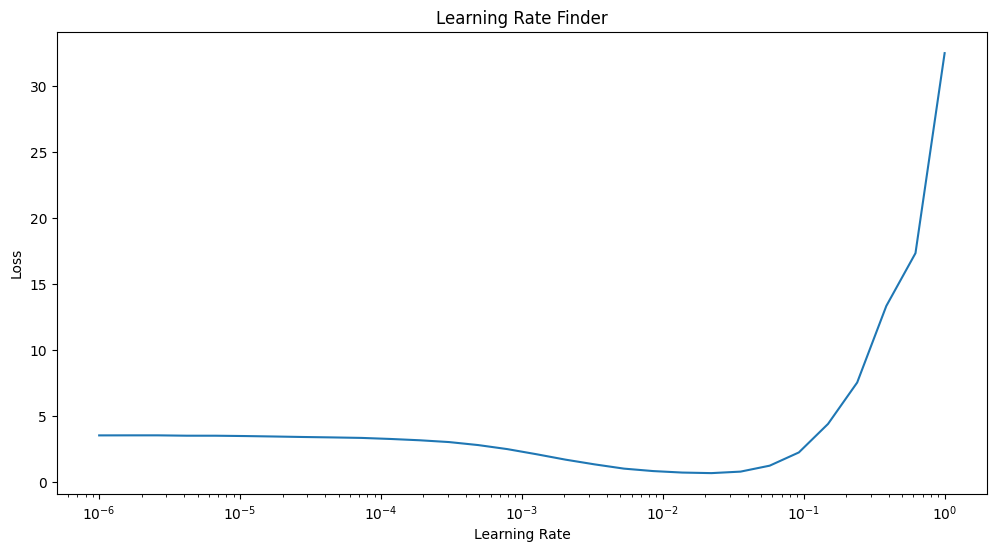

In [ ]:
# lrs = []
# losses = []
# count = 0

# for lr in np.logspace(-6, 0, 30):
#     optimizer = optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9)
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         inputs, labels = data
#         optimizer.zero_grad()
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#         if i == 100:  # Stop early to speed up the process
#             count += 1
#             # print(count)
#             break
#     lrs.append(lr)
#     losses.append(running_loss / 100)

# plt.figure(figsize=(12, 6))
# plt.plot(lrs, losses)
# plt.xscale("log")
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.title("Learning Rate Finder")
# plt.show()


## Training funcion


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []


def train(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()  # Put model into train mode
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            train_losses.append(loss.item())
            accuracy = 100 * correct / ((i + 1) * trainloader.batch_size)
            if (i + 1) % 100 == 0:
                train_accuracy.append(accuracy)
                print(
                    f"Epoch [{epoch + 1}/{10}], Iteration [{i + 1}/{len(trainloader)}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%"
                )
        correct = 0
        model.eval()
        # validation loop
        with torch.no_grad():
            for images, labels in valloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum()
                val_losses.append(loss.item())
            accuracy = 100 * (correct.item()) / len(val_set)
            val_accuracy.append(accuracy)

    # set the model back to train mode
    model.train()

    print("Finished Training")


In [12]:
num_epochs = 10
train(model, trainloader, valloader, criterion, optimizer, num_epochs=num_epochs)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Iteration [100/1740], Loss: 1.0046, Accuracy: 41.04%
Epoch [1/10], Iteration [200/1740], Loss: 0.7863, Accuracy: 56.80%
Epoch [1/10], Iteration [300/1740], Loss: 0.5695, Accuracy: 64.85%
Epoch [1/10], Iteration [400/1740], Loss: 0.3926, Accuracy: 69.54%
Epoch [1/10], Iteration [500/1740], Loss: 0.5397, Accuracy: 72.62%
Epoch [1/10], Iteration [600/1740], Loss: 0.3391, Accuracy: 75.06%
Epoch [1/10], Iteration [700/1740], Loss: 0.3346, Accuracy: 76.91%
Epoch [1/10], Iteration [800/1740], Loss: 0.3449, Accuracy: 78.14%
Epoch [1/10], Iteration [900/1740], Loss: 0.4196, Accuracy: 79.49%
Epoch [1/10], Iteration [1000/1740], Loss: 0.3556, Accuracy: 80.50%
Epoch [1/10], Iteration [1100/1740], Loss: 0.2339, Accuracy: 81.41%
Epoch [1/10], Iteration [1200/1740], Loss: 0.5635, Accuracy: 82.19%
Epoch [1/10], Iteration [1300/1740], Loss: 0.3331, Accuracy: 82.78%
Epoch [1/10], Iteration [1400/1740], Loss: 0.1721, Accuracy: 83.30%
Epoch [1/10], Iteration [1500/1740], Loss: 0.4537, Accura

 10%|█         | 1/10 [03:49<34:21, 229.10s/it]

Epoch [2/10], Iteration [100/1740], Loss: 0.2225, Accuracy: 92.89%
Epoch [2/10], Iteration [200/1740], Loss: 0.2299, Accuracy: 92.82%
Epoch [2/10], Iteration [300/1740], Loss: 0.5785, Accuracy: 92.76%
Epoch [2/10], Iteration [400/1740], Loss: 0.2179, Accuracy: 92.72%
Epoch [2/10], Iteration [500/1740], Loss: 0.1583, Accuracy: 92.52%
Epoch [2/10], Iteration [600/1740], Loss: 0.2773, Accuracy: 92.65%
Epoch [2/10], Iteration [700/1740], Loss: 0.2130, Accuracy: 92.68%
Epoch [2/10], Iteration [800/1740], Loss: 0.3736, Accuracy: 92.70%
Epoch [2/10], Iteration [900/1740], Loss: 0.1908, Accuracy: 92.71%
Epoch [2/10], Iteration [1000/1740], Loss: 0.0711, Accuracy: 92.74%
Epoch [2/10], Iteration [1100/1740], Loss: 0.1814, Accuracy: 92.75%
Epoch [2/10], Iteration [1200/1740], Loss: 0.2309, Accuracy: 92.80%
Epoch [2/10], Iteration [1300/1740], Loss: 0.2019, Accuracy: 92.79%
Epoch [2/10], Iteration [1400/1740], Loss: 0.3285, Accuracy: 92.78%
Epoch [2/10], Iteration [1500/1740], Loss: 0.3157, Accura

 20%|██        | 2/10 [07:41<30:48, 231.12s/it]

Epoch [3/10], Iteration [100/1740], Loss: 0.4021, Accuracy: 94.50%
Epoch [3/10], Iteration [200/1740], Loss: 0.0881, Accuracy: 94.36%
Epoch [3/10], Iteration [300/1740], Loss: 0.1648, Accuracy: 94.49%
Epoch [3/10], Iteration [400/1740], Loss: 0.1600, Accuracy: 94.41%
Epoch [3/10], Iteration [500/1740], Loss: 0.3623, Accuracy: 94.31%
Epoch [3/10], Iteration [600/1740], Loss: 0.1276, Accuracy: 94.53%
Epoch [3/10], Iteration [700/1740], Loss: 0.2489, Accuracy: 94.48%
Epoch [3/10], Iteration [800/1740], Loss: 0.2760, Accuracy: 94.30%
Epoch [3/10], Iteration [900/1740], Loss: 0.1387, Accuracy: 94.32%
Epoch [3/10], Iteration [1000/1740], Loss: 0.2017, Accuracy: 94.29%
Epoch [3/10], Iteration [1100/1740], Loss: 0.2345, Accuracy: 94.27%
Epoch [3/10], Iteration [1200/1740], Loss: 0.2840, Accuracy: 94.22%
Epoch [3/10], Iteration [1300/1740], Loss: 0.1902, Accuracy: 94.25%
Epoch [3/10], Iteration [1400/1740], Loss: 0.1680, Accuracy: 94.25%
Epoch [3/10], Iteration [1500/1740], Loss: 0.1375, Accura

 30%|███       | 3/10 [11:40<27:22, 234.70s/it]

Epoch [4/10], Iteration [100/1740], Loss: 0.4377, Accuracy: 95.43%
Epoch [4/10], Iteration [200/1740], Loss: 0.1993, Accuracy: 94.93%
Epoch [4/10], Iteration [300/1740], Loss: 0.1854, Accuracy: 94.77%
Epoch [4/10], Iteration [400/1740], Loss: 0.0806, Accuracy: 94.92%
Epoch [4/10], Iteration [500/1740], Loss: 0.1526, Accuracy: 95.03%
Epoch [4/10], Iteration [600/1740], Loss: 0.0887, Accuracy: 95.05%
Epoch [4/10], Iteration [700/1740], Loss: 0.0399, Accuracy: 95.11%
Epoch [4/10], Iteration [800/1740], Loss: 0.1701, Accuracy: 95.12%
Epoch [4/10], Iteration [900/1740], Loss: 0.0757, Accuracy: 95.07%
Epoch [4/10], Iteration [1000/1740], Loss: 0.0452, Accuracy: 95.01%
Epoch [4/10], Iteration [1100/1740], Loss: 0.1558, Accuracy: 94.97%
Epoch [4/10], Iteration [1200/1740], Loss: 0.0932, Accuracy: 94.96%
Epoch [4/10], Iteration [1300/1740], Loss: 0.1728, Accuracy: 94.90%
Epoch [4/10], Iteration [1400/1740], Loss: 0.1167, Accuracy: 94.92%
Epoch [4/10], Iteration [1500/1740], Loss: 0.2608, Accura

 40%|████      | 4/10 [14:55<21:54, 219.05s/it]

Epoch [5/10], Iteration [100/1740], Loss: 0.0973, Accuracy: 96.29%
Epoch [5/10], Iteration [200/1740], Loss: 0.1914, Accuracy: 95.79%
Epoch [5/10], Iteration [300/1740], Loss: 0.0704, Accuracy: 95.40%
Epoch [5/10], Iteration [400/1740], Loss: 0.1975, Accuracy: 95.42%
Epoch [5/10], Iteration [500/1740], Loss: 0.1121, Accuracy: 95.59%
Epoch [5/10], Iteration [600/1740], Loss: 0.1885, Accuracy: 95.51%
Epoch [5/10], Iteration [700/1740], Loss: 0.0997, Accuracy: 95.47%
Epoch [5/10], Iteration [800/1740], Loss: 0.0893, Accuracy: 95.41%
Epoch [5/10], Iteration [900/1740], Loss: 0.0703, Accuracy: 95.31%
Epoch [5/10], Iteration [1000/1740], Loss: 0.1849, Accuracy: 95.24%
Epoch [5/10], Iteration [1100/1740], Loss: 0.2051, Accuracy: 95.20%
Epoch [5/10], Iteration [1200/1740], Loss: 0.3569, Accuracy: 95.16%
Epoch [5/10], Iteration [1300/1740], Loss: 0.0822, Accuracy: 95.20%
Epoch [5/10], Iteration [1400/1740], Loss: 0.1739, Accuracy: 95.27%
Epoch [5/10], Iteration [1500/1740], Loss: 0.1433, Accura

 50%|█████     | 5/10 [18:01<17:15, 207.05s/it]

Epoch [6/10], Iteration [100/1740], Loss: 0.0665, Accuracy: 95.43%
Epoch [6/10], Iteration [200/1740], Loss: 0.0808, Accuracy: 95.55%
Epoch [6/10], Iteration [300/1740], Loss: 0.1695, Accuracy: 95.63%
Epoch [6/10], Iteration [400/1740], Loss: 0.0978, Accuracy: 95.68%
Epoch [6/10], Iteration [500/1740], Loss: 0.0464, Accuracy: 95.79%
Epoch [6/10], Iteration [600/1740], Loss: 0.0849, Accuracy: 95.71%
Epoch [6/10], Iteration [700/1740], Loss: 0.0500, Accuracy: 95.70%
Epoch [6/10], Iteration [800/1740], Loss: 0.0678, Accuracy: 95.74%
Epoch [6/10], Iteration [900/1740], Loss: 0.2806, Accuracy: 95.71%
Epoch [6/10], Iteration [1000/1740], Loss: 0.3625, Accuracy: 95.72%
Epoch [6/10], Iteration [1100/1740], Loss: 0.0711, Accuracy: 95.71%
Epoch [6/10], Iteration [1200/1740], Loss: 0.1009, Accuracy: 95.74%
Epoch [6/10], Iteration [1300/1740], Loss: 0.0451, Accuracy: 95.71%
Epoch [6/10], Iteration [1400/1740], Loss: 0.2054, Accuracy: 95.72%
Epoch [6/10], Iteration [1500/1740], Loss: 0.2307, Accura

 60%|██████    | 6/10 [21:30<13:51, 207.77s/it]

Epoch [7/10], Iteration [100/1740], Loss: 0.0844, Accuracy: 95.32%
Epoch [7/10], Iteration [200/1740], Loss: 0.1744, Accuracy: 95.71%
Epoch [7/10], Iteration [300/1740], Loss: 0.1073, Accuracy: 95.65%
Epoch [7/10], Iteration [400/1740], Loss: 0.1824, Accuracy: 95.55%
Epoch [7/10], Iteration [500/1740], Loss: 0.3537, Accuracy: 95.50%
Epoch [7/10], Iteration [600/1740], Loss: 0.2770, Accuracy: 95.57%
Epoch [7/10], Iteration [700/1740], Loss: 0.1701, Accuracy: 95.72%
Epoch [7/10], Iteration [800/1740], Loss: 0.2775, Accuracy: 95.81%
Epoch [7/10], Iteration [900/1740], Loss: 0.0261, Accuracy: 95.88%
Epoch [7/10], Iteration [1000/1740], Loss: 0.0300, Accuracy: 95.85%
Epoch [7/10], Iteration [1100/1740], Loss: 0.1126, Accuracy: 95.84%
Epoch [7/10], Iteration [1200/1740], Loss: 0.0872, Accuracy: 95.80%
Epoch [7/10], Iteration [1300/1740], Loss: 0.3513, Accuracy: 95.79%
Epoch [7/10], Iteration [1400/1740], Loss: 0.0326, Accuracy: 95.77%
Epoch [7/10], Iteration [1500/1740], Loss: 0.0191, Accura

 70%|███████   | 7/10 [24:38<10:03, 201.31s/it]

Epoch [8/10], Iteration [100/1740], Loss: 0.1323, Accuracy: 96.39%
Epoch [8/10], Iteration [200/1740], Loss: 0.1830, Accuracy: 96.43%
Epoch [8/10], Iteration [300/1740], Loss: 0.1621, Accuracy: 96.38%
Epoch [8/10], Iteration [400/1740], Loss: 0.0282, Accuracy: 96.46%
Epoch [8/10], Iteration [500/1740], Loss: 0.0582, Accuracy: 96.50%
Epoch [8/10], Iteration [600/1740], Loss: 0.0608, Accuracy: 96.46%
Epoch [8/10], Iteration [700/1740], Loss: 0.0652, Accuracy: 96.45%
Epoch [8/10], Iteration [800/1740], Loss: 0.1236, Accuracy: 96.45%
Epoch [8/10], Iteration [900/1740], Loss: 0.2855, Accuracy: 96.40%
Epoch [8/10], Iteration [1000/1740], Loss: 0.1274, Accuracy: 96.47%
Epoch [8/10], Iteration [1100/1740], Loss: 0.2683, Accuracy: 96.41%
Epoch [8/10], Iteration [1200/1740], Loss: 0.1143, Accuracy: 96.36%
Epoch [8/10], Iteration [1300/1740], Loss: 0.0639, Accuracy: 96.33%
Epoch [8/10], Iteration [1400/1740], Loss: 0.1536, Accuracy: 96.35%
Epoch [8/10], Iteration [1500/1740], Loss: 0.0416, Accura

 80%|████████  | 8/10 [27:47<06:34, 197.25s/it]

Epoch [9/10], Iteration [100/1740], Loss: 0.1230, Accuracy: 96.57%
Epoch [9/10], Iteration [200/1740], Loss: 0.0983, Accuracy: 96.55%
Epoch [9/10], Iteration [300/1740], Loss: 0.1402, Accuracy: 96.58%
Epoch [9/10], Iteration [400/1740], Loss: 0.0191, Accuracy: 96.46%
Epoch [9/10], Iteration [500/1740], Loss: 0.1016, Accuracy: 96.39%
Epoch [9/10], Iteration [600/1740], Loss: 0.0704, Accuracy: 96.51%
Epoch [9/10], Iteration [700/1740], Loss: 0.0922, Accuracy: 96.57%
Epoch [9/10], Iteration [800/1740], Loss: 0.3062, Accuracy: 96.51%
Epoch [9/10], Iteration [900/1740], Loss: 0.0896, Accuracy: 96.47%
Epoch [9/10], Iteration [1000/1740], Loss: 0.1037, Accuracy: 96.42%
Epoch [9/10], Iteration [1100/1740], Loss: 0.0399, Accuracy: 96.43%
Epoch [9/10], Iteration [1200/1740], Loss: 0.0767, Accuracy: 96.41%
Epoch [9/10], Iteration [1300/1740], Loss: 0.0319, Accuracy: 96.36%
Epoch [9/10], Iteration [1400/1740], Loss: 0.1374, Accuracy: 96.35%
Epoch [9/10], Iteration [1500/1740], Loss: 0.0398, Accura

 90%|█████████ | 9/10 [30:38<03:09, 189.28s/it]

Epoch [10/10], Iteration [100/1740], Loss: 0.0956, Accuracy: 96.61%
Epoch [10/10], Iteration [200/1740], Loss: 0.4993, Accuracy: 96.43%
Epoch [10/10], Iteration [300/1740], Loss: 0.0889, Accuracy: 96.58%
Epoch [10/10], Iteration [400/1740], Loss: 0.0583, Accuracy: 96.62%
Epoch [10/10], Iteration [500/1740], Loss: 0.1254, Accuracy: 96.61%
Epoch [10/10], Iteration [600/1740], Loss: 0.1010, Accuracy: 96.60%
Epoch [10/10], Iteration [700/1740], Loss: 0.2604, Accuracy: 96.60%
Epoch [10/10], Iteration [800/1740], Loss: 0.0578, Accuracy: 96.68%
Epoch [10/10], Iteration [900/1740], Loss: 0.2270, Accuracy: 96.61%
Epoch [10/10], Iteration [1000/1740], Loss: 0.0508, Accuracy: 96.55%
Epoch [10/10], Iteration [1100/1740], Loss: 0.1649, Accuracy: 96.52%
Epoch [10/10], Iteration [1200/1740], Loss: 0.1349, Accuracy: 96.51%
Epoch [10/10], Iteration [1300/1740], Loss: 0.2719, Accuracy: 96.52%
Epoch [10/10], Iteration [1400/1740], Loss: 0.0501, Accuracy: 96.47%
Epoch [10/10], Iteration [1500/1740], Loss:

100%|██████████| 10/10 [33:33<00:00, 201.39s/it]

Finished Training


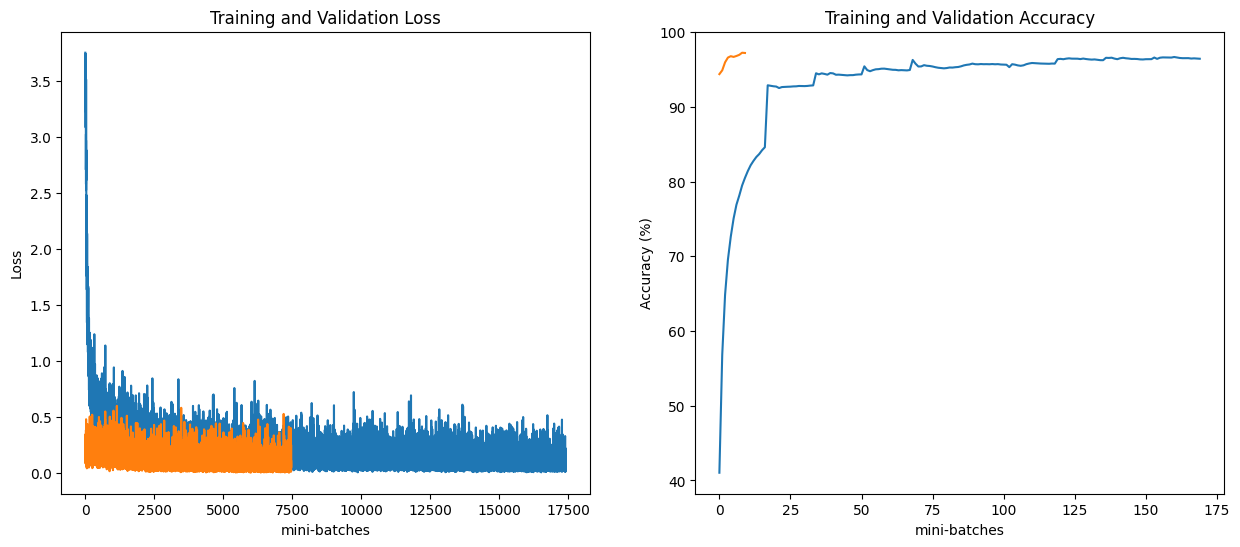

In [13]:
import matplotlib.pyplot as plt

rows = 1
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
for j in range(cols):
    if j == 0:
        axes[j].plot(train_losses, label="Train Loss")
        axes[j].plot(val_losses, label="Train Loss")
        axes[j].set_title("Training and Validation Loss")
        axes[j].set_xlabel("mini-batches")
        axes[j].set_ylabel("Loss")
    elif j == 1:
        axes[j].plot(train_accuracy, label="training Accuracy")
        axes[j].plot(val_accuracy, label="validation Accuracy")
        axes[j].set_title("Training and Validation Accuracy")
        axes[j].set_xlabel("mini-batches")
        axes[j].set_ylabel("Accuracy (%)")


## Testing


In [14]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from sklearn.metrics import accuracy_score

y_true = []
y_pred = []
model.eval()
test_correct = 0
total = 0
# Testing loop
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # labels = labels.to(device)
        outputs = model(inputs)

        _, test_pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        test_correct += (test_pred == labels).sum().item()

        for idx, item in enumerate(labels):
            y_true.append(labels[idx].item())
            y_pred.append(test_pred[idx].item())


## confusion matrix


Accuracy of the network on the test images: 96.95 %


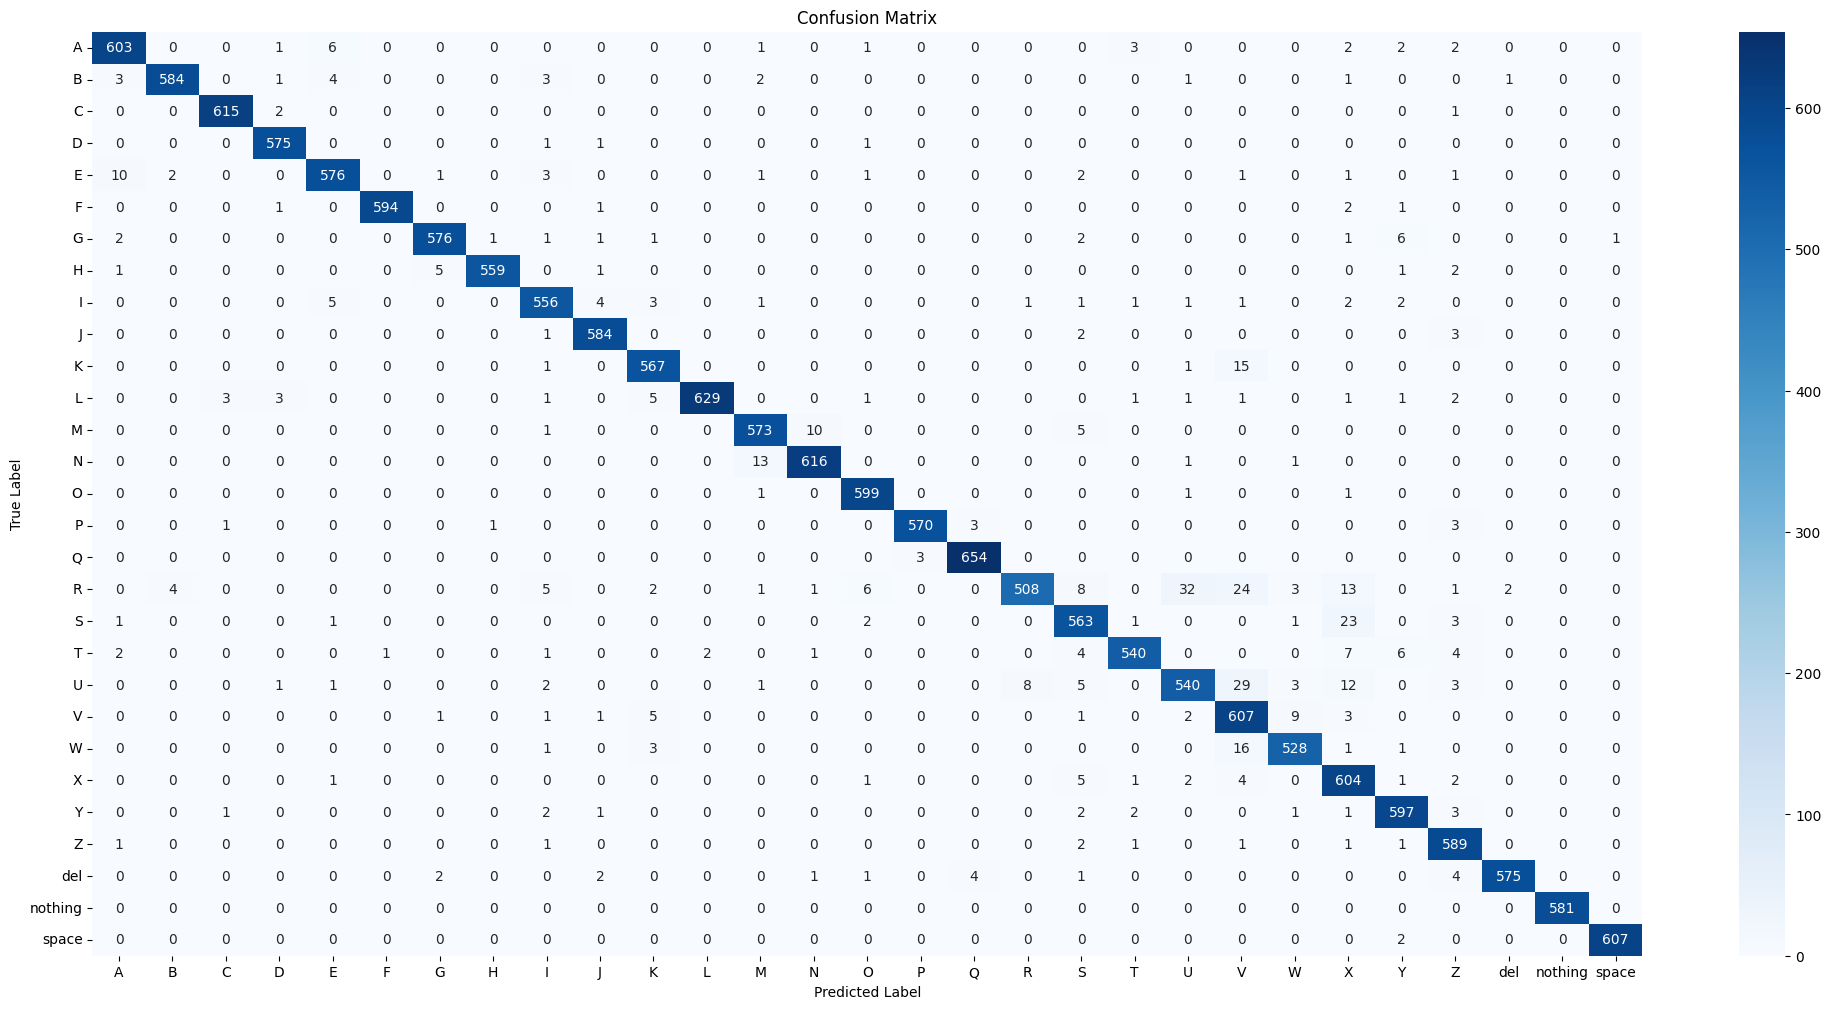

F1 Score:  0.9694827586206897


In [15]:
print(f"Accuracy of the network on the test images: {100 * test_correct / total:.2f} %")
# Find and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)  # <<<<<<< your code here >>>>>>>>
plt.figure(figsize=(25, 12))
sns.heatmap(
    conf_matrix,
    annot=True,
    xticklabels=train_ds.class_to_idx.keys(),
    yticklabels=train_ds.class_to_idx.keys(),
    fmt="d",
    cmap="Blues",
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

acc = accuracy_score(y_true, y_pred, normalize=True)  # <<<<<<< your code here >>>>>>>>
print("F1 Score: ", acc)


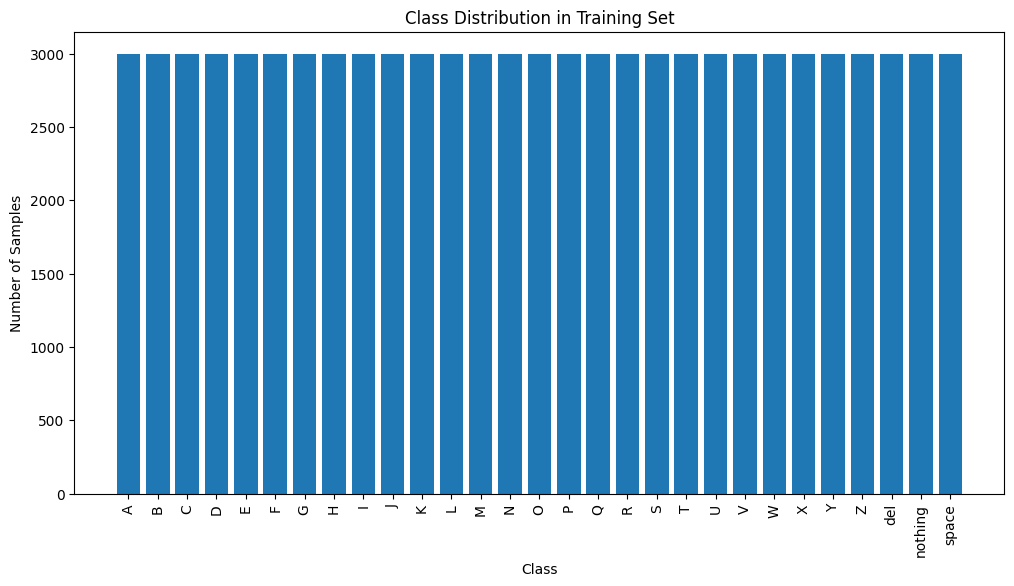

In [16]:
# class distribution
class_counts = [0] * len(train_ds.classes)
for _, label in train_ds.samples:
    class_counts[label] += 1

plt.figure(figsize=(12, 6))
plt.bar(range(len(train_ds.classes)), class_counts, tick_label=train_ds.classes)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=90)
plt.show()


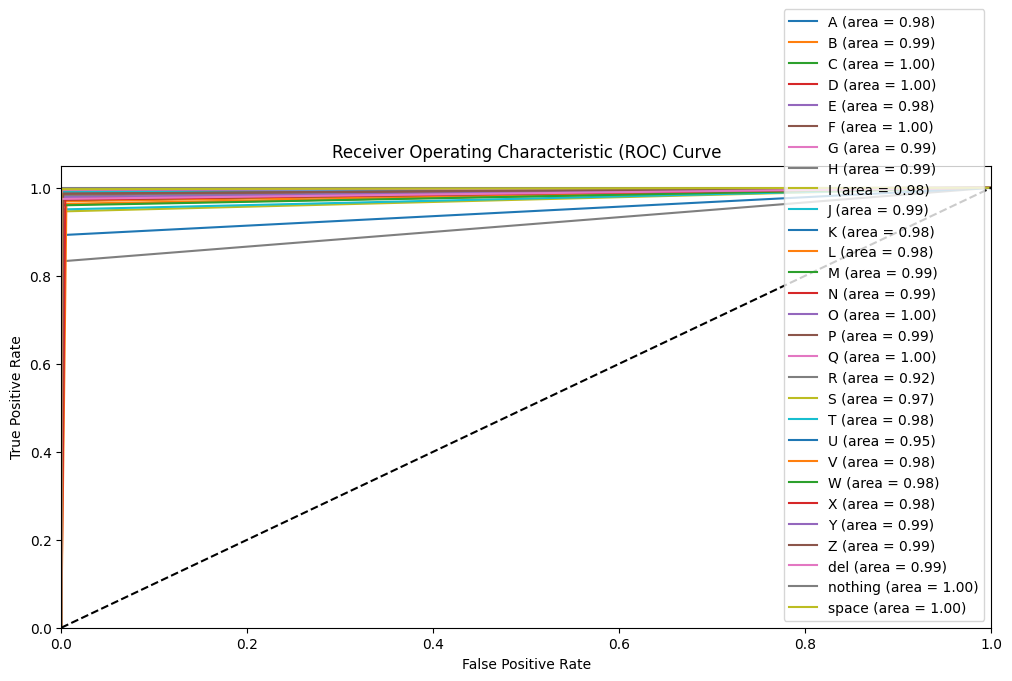

In [17]:
# target_names = train_ds.class_to_idx
# target_names

# ROC CURVE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(len(train_ds.classes)))
y_pred_bin = label_binarize(y_pred, classes=range(len(train_ds.classes)))

plt.figure(figsize=(12, 6))
for i in range(len(train_ds.classes)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{train_ds.classes[i]} (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


Accuracy of A : 97.10%
Accuracy of B : 97.33%
Accuracy of C : 99.51%
Accuracy of D : 99.48%
Accuracy of E : 96.16%
Accuracy of F : 99.17%
Accuracy of G : 97.30%
Accuracy of H : 98.24%
Accuracy of I : 96.19%
Accuracy of J : 98.98%
Accuracy of K : 97.09%
Accuracy of L : 96.92%
Accuracy of M : 97.28%
Accuracy of N : 97.62%
Accuracy of O : 99.50%
Accuracy of P : 98.62%
Accuracy of Q : 99.54%
Accuracy of R : 83.28%
Accuracy of S : 94.62%
Accuracy of T : 95.07%
Accuracy of U : 89.26%
Accuracy of V : 96.35%
Accuracy of W : 96.00%
Accuracy of X : 97.26%
Accuracy of Y : 97.87%
Accuracy of Z : 98.66%
Accuracy of del : 97.46%
Accuracy of nothing : 100.00%
Accuracy of space : 99.67%


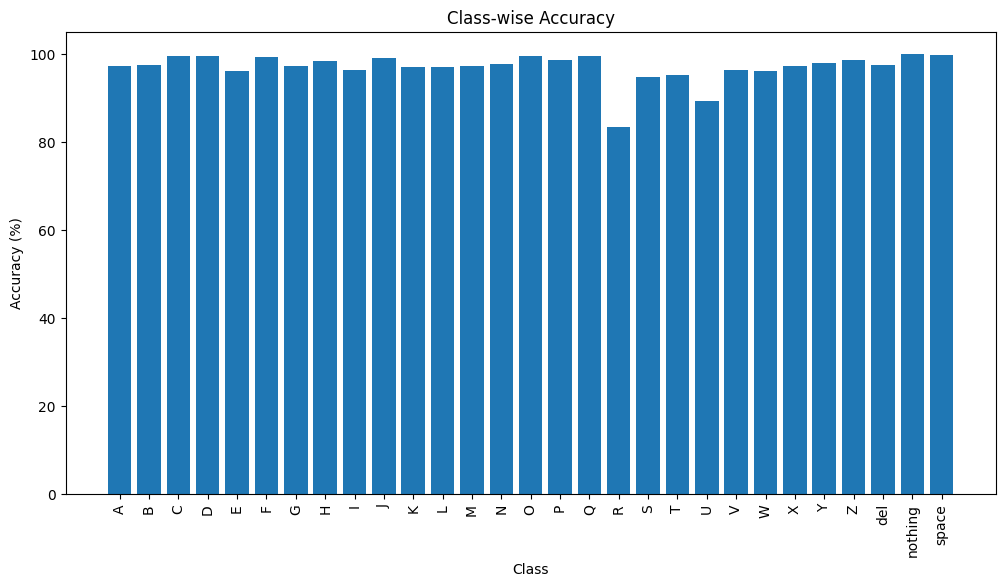

In [18]:
## class accuracies
class_correct = list(0.0 for i in range(len(train_ds.classes)))
class_total = list(0.0 for i in range(len(train_ds.classes)))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(train_ds.classes)):
    print(
        f"Accuracy of {train_ds.classes[i]} : {100 * class_correct[i] / class_total[i]:.2f}%"
    )

plt.figure(figsize=(12, 6))
plt.bar(
    range(len(train_ds.classes)),
    [100 * class_correct[i] / class_total[i] for i in range(len(train_ds.classes))],
)
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy")
plt.xticks(range(len(train_ds.classes)), train_ds.classes, rotation=90)
plt.show()


Accuracy of the network on the test images: 96.95 %


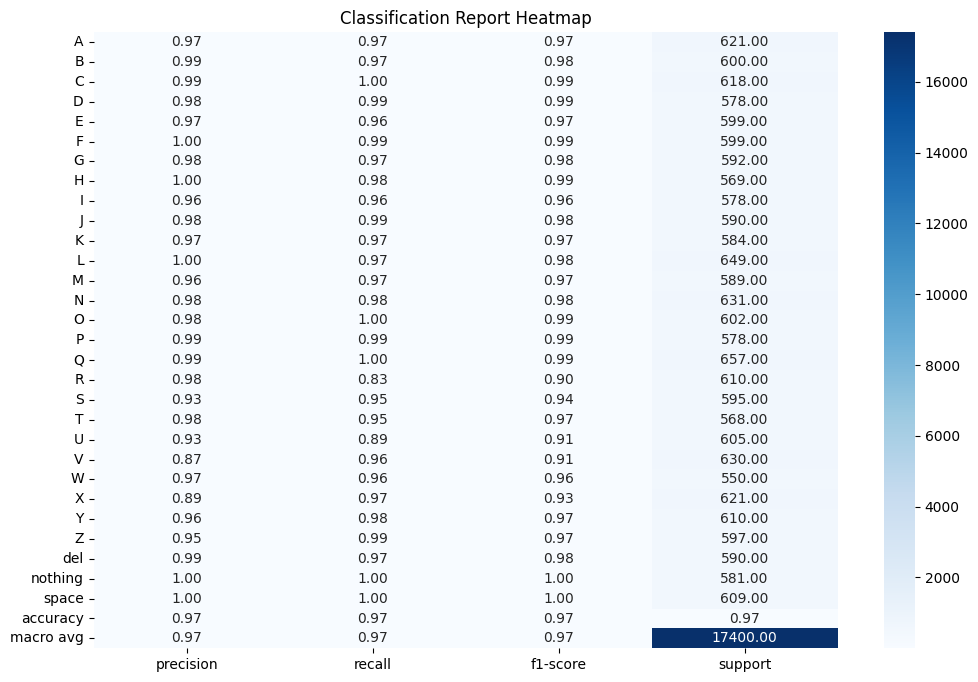

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Testing loop to collect predictions and true labels
y_true = []
y_pred = []
model.eval()
test_correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        test_correct += (test_pred == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(test_pred.cpu().numpy())

# Print test accuracy
print(f"Accuracy of the network on the test images: {100 * test_correct / total:.2f} %")

# Generate the classification report
report = classification_report(
    y_true, y_pred, target_names=[str(i) for i in train_ds.classes], output_dict=True
)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()
